In [9]:
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn.functional as F

In [2]:
scaling = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True)
]
)
train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=scaling)

data = train_data.data
labels = train_data.targets
print(f'There are {len(data)} observations - each represent image of 28x28.')

There are 60000 observations - each represent image of 28x28.


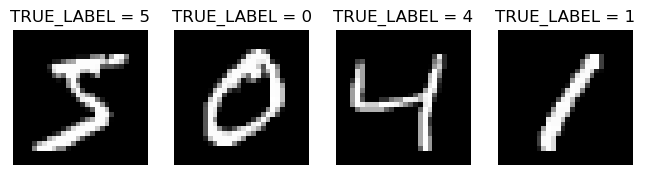

In [3]:
#========================================
# PART A
#========================================

single_plot = lambda x: plt.imshow(x, cmap="gray")
# single_plot(data[0])

def plot_images(k : int):
    fig, ax = plt.subplots(1,k,figsize=(8,8*8))
    for i in range(k):
        ax[i].imshow(data[i],cmap="gray")
        ax[i].set_title(f'TRUE_LABEL = {labels[i]}')
        ax[i].axis("off")

plot_images(4)

In [4]:
#========================================
# PART B
#========================================

filtered_data, filtered_labels = data[:10_000], labels[:10_000]
flattened_data = filtered_data.flatten(start_dim=1) # flatten to vector

def normalize(arr : torch.tensor):
    min_, max_ = arr.min(), arr.max()
    diff = max_ - min_
    if diff == 0:
        return torch.zeros_like(arr)
    return (arr - min_) / diff

normalized_data = torch.stack([normalize(x) for x in flattened_data])

In [ ]:
#========================================
# PART C
#========================================

X = normalized_data # [10000, 784]
y = filtered_labels # [10000]

N = 4                 # batch size
D_in = 784            # input dim
H = 128               # hidden dim
D_out = 10            # number of classes

W1 = torch.full((D_in, H), 0.01, requires_grad=True)  # [784, 128]
b1 = torch.full((H,),      0.01, requires_grad=True)  # [128]

W2 = torch.full((H, D_out), 0.01, requires_grad=True) # [128, 10]
b2 = torch.full((D_out,),    0.01, requires_grad=True) # [10]

In [17]:
#===========================================
# PART D
#===========================================

def predict(X, W1, b1, W2, b2):
    h1 = F.relu(X @ W1 + b1)   # hidden layer
    Y  = h1 @ W2 + b2          # output layer
    return Y

Y = predict(X, W1, b1, W2, b2)
print(Y)

tensor([[1.4044, 1.4044, 1.4044,  ..., 1.4044, 1.4044, 1.4044],
        [1.5836, 1.5836, 1.5836,  ..., 1.5836, 1.5836, 1.5836],
        [0.9988, 0.9988, 0.9988,  ..., 0.9988, 0.9988, 0.9988],
        ...,
        [1.4374, 1.4374, 1.4374,  ..., 1.4374, 1.4374, 1.4374],
        [0.9893, 0.9893, 0.9893,  ..., 0.9893, 0.9893, 0.9893],
        [1.0575, 1.0575, 1.0575,  ..., 1.0575, 1.0575, 1.0575]],
       grad_fn=<AddBackward0>)


In [27]:
def train_network(X, y, init_type="fixed", steps=1000, lr=0.001, seed=0):

    N, D_in = X.shape
    H, D_out = 128, 10
    torch.manual_seed(seed)

    # --- Initialize weights ---
    if init_type == "fixed":
        W1 = torch.full((D_in, H), 0.01, requires_grad=True)
        b1 = torch.full((H,), 0.01, requires_grad=True)
        W2 = torch.full((H, D_out), 0.01, requires_grad=True)
        b2 = torch.full((D_out,), 0.01, requires_grad=True)
    elif init_type in ["random", "adam"]:
        W1 = (torch.randn(D_in, H) * 0.1).requires_grad_()
        b1 = torch.zeros(H, requires_grad=True)
        W2 = (torch.randn(H, D_out) * 0.1).requires_grad_()
        b2 = torch.zeros(D_out, requires_grad=True)
    else:
        raise ValueError("init_type must be 'fixed', 'random', or 'adam'")

    loss_fn = torch.nn.CrossEntropyLoss()
    losses = []

    # --- Choose optimizer ---
    if init_type == "adam":
        optimizer = torch.optim.Adam([W1, b1, W2, b2], lr=lr)

    # --- Training loop ---
    for step in range(1, steps+1):
        logits = predict(X, W1, b1, W2, b2)
        loss = loss_fn(logits, y)
        losses.append(loss.item())

        if init_type == "adam":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:  # manual GD
            loss.backward()
            with torch.no_grad():
                W1 -= lr * W1.grad
                b1 -= lr * b1.grad
                W2 -= lr * W2.grad
                b2 -= lr * b2.grad
            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()

        if step % 100 == 0:
            print(f"[{init_type}] Step {step}: Loss = {loss.item():.4f}")

    return losses

[fixed] Step 100: Loss = 2.2891
[fixed] Step 200: Loss = 2.2881
[fixed] Step 300: Loss = 2.2876
[fixed] Step 400: Loss = 2.2873
[fixed] Step 500: Loss = 2.2869
[fixed] Step 600: Loss = 2.2865
[fixed] Step 700: Loss = 2.2862
[fixed] Step 800: Loss = 2.2858
[fixed] Step 900: Loss = 2.2854
[fixed] Step 1000: Loss = 2.2850
[random] Step 100: Loss = 2.4072
[random] Step 200: Loss = 2.2786
[random] Step 300: Loss = 2.1761
[random] Step 400: Loss = 2.0865
[random] Step 500: Loss = 2.0044
[random] Step 600: Loss = 1.9274
[random] Step 700: Loss = 1.8545
[random] Step 800: Loss = 1.7850
[random] Step 900: Loss = 1.7187
[random] Step 1000: Loss = 1.6554
[adam] Step 100: Loss = 0.2386
[adam] Step 200: Loss = 0.1251
[adam] Step 300: Loss = 0.0697
[adam] Step 400: Loss = 0.0402
[adam] Step 500: Loss = 0.0241
[adam] Step 600: Loss = 0.0152
[adam] Step 700: Loss = 0.0102
[adam] Step 800: Loss = 0.0072
[adam] Step 900: Loss = 0.0053
[adam] Step 1000: Loss = 0.0041


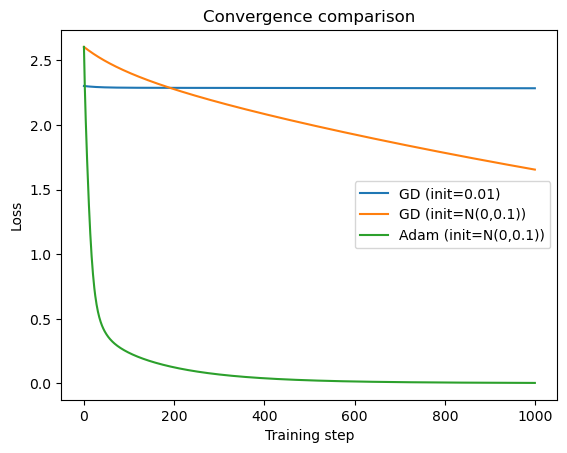

In [28]:
losses_fixed  = train_network(X, y, init_type="fixed")
losses_random = train_network(X, y, init_type="random")
losses_adam   = train_network(X, y, init_type="adam")

plt.plot(losses_fixed,  label="GD (init=0.01)")
plt.plot(losses_random, label="GD (init=N(0,0.1))")
plt.plot(losses_adam,   label="Adam (init=N(0,0.1))")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence comparison")
plt.show()

Adam > random initialization > constant intialization.